In [32]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [33]:
i_s = 227
b_s = 32
ch = 3
ep = 15

In [34]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    "Preprocessed data",
    shuffle = True,
    image_size = (i_s , i_s),
    batch_size = b_s
)

Found 11395 files belonging to 10 classes.


In [35]:
class_names = dataset.class_names
class_names

['Bacterial_spot227',
 'Early_blight227',
 'Late_blight227',
 'Leaf_Mold227',
 'Septoria_leaf_spot227',
 'Target_Spot227',
 'Tomato_Yellow_Leaf_Curl_Virus227',
 'Tomato_mosaic_virus227',
 'Two-spotted_spider_mite227',
 'healthy227']

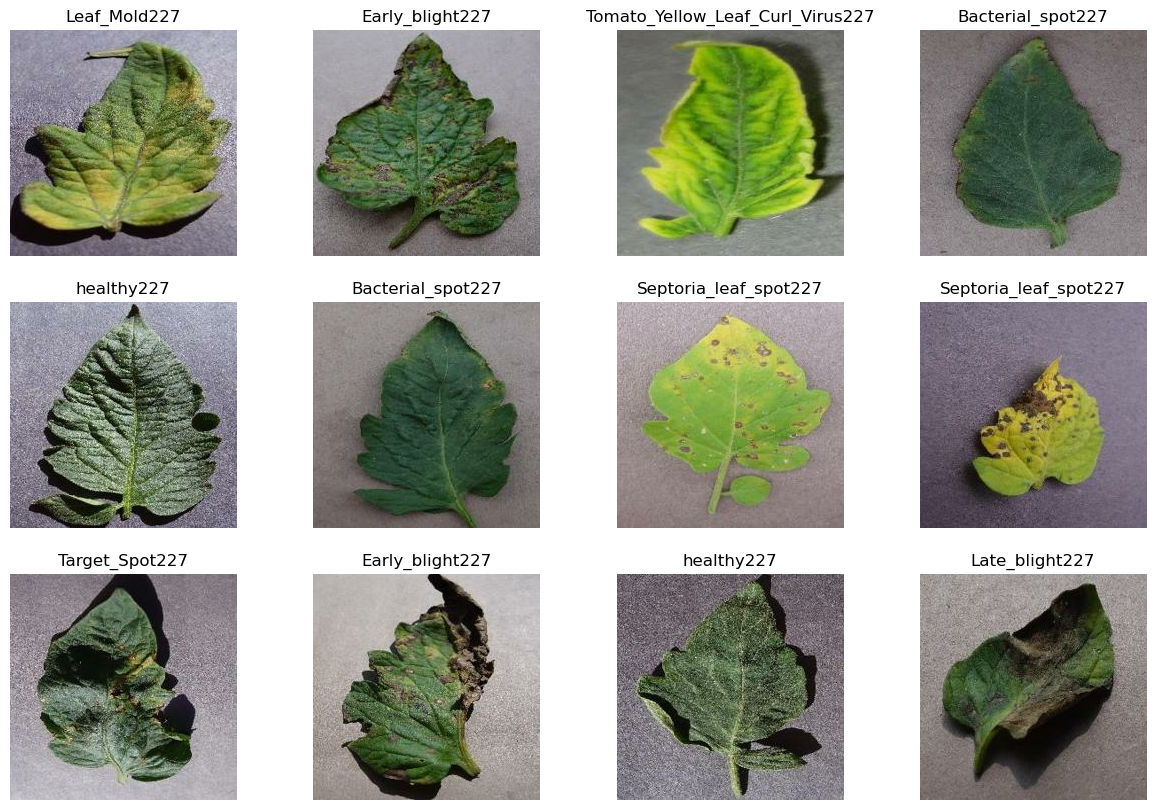

In [36]:
plt.figure(figsize =(15,10))
for i_b, l_b in dataset.take(1):
    for i in range(12):  
        plt.subplot(3,4,i+1)
        plt.imshow(i_b[i].numpy().astype("uint8"))
        plt.title(class_names[l_b[i]])
        plt.axis("off")
        
    

In [37]:
len(dataset)

357

In [38]:
def get_dataset_partitions_tf(ds, train_split =0.8, val_split =0.1, test_split =0.1, shuffle =True, shuffle_size =1000):
    ds_size = len(ds)
    if shuffle:
        df = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip (train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [39]:
train_ds,val_ds,test_ds =get_dataset_partitions_tf(dataset)

In [40]:
print(len(train_ds),len(val_ds),len(test_ds))

285 35 37


In [41]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size =tf.data.AUTOTUNE)

In [42]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(i_s,i_s),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


In [43]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
input_shape = (b_s,i_s,i_s,ch)
n_classes =10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation ='relu'),
    layers.Dense(n_classes, activation ='softmax')
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 227, 227, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 227, 227, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 225, 225, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 112, 112, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 110, 110, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 55, 55, 64)          0         
 g2D)                                                 

In [47]:
model.compile(
    optimizer ='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics =['accuracy'])

In [48]:
ES = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [49]:
history =model.fit(
    train_ds,
    epochs = ep,
    batch_size = b_s,
    verbose = 1,
    validation_data = val_ds,
    callbacks=[ES]
)

Epoch 1/15
285/285 [==============================] - 725s 2s/step - loss: 1.6763 - accuracy: 0.3922 - val_loss: 1.1987 - val_accuracy: 0.6062
Epoch 2/15
285/285 [==============================] - 709s 2s/step - loss: 1.0609 - accuracy: 0.6288 - val_loss: 0.7295 - val_accuracy: 0.7464
Epoch 3/15
285/285 [==============================] - 701s 2s/step - loss: 0.7021 - accuracy: 0.7513 - val_loss: 0.6893 - val_accuracy: 0.7580
Epoch 4/15
285/285 [==============================] - 697s 2s/step - loss: 0.5589 - accuracy: 0.8013 - val_loss: 0.6299 - val_accuracy: 0.7554
Epoch 5/15
285/285 [==============================] - 693s 2s/step - loss: 0.4512 - accuracy: 0.8408 - val_loss: 0.5723 - val_accuracy: 0.7946
Epoch 6/15
285/285 [==============================] - 685s 2s/step - loss: 0.4200 - accuracy: 0.8521 - val_loss: 0.5478 - val_accuracy: 0.8036
Epoch 7/15
285/285 [==============================] - 687s 2s/step - loss: 0.3769 - accuracy: 0.8669 - val_loss: 0.3887 - val_accuracy: 0.8580

In [61]:
model.save("simple_cnn_model1")

INFO:tensorflow:Assets written to: simple_cnn_model1\assets


INFO:tensorflow:Assets written to: simple_cnn_model1\assets


In [51]:
scores = model.evaluate(test_ds)

37/37 [==============================] - 27s 464ms/step - loss: 0.2732 - accuracy: 0.9169


In [52]:
scores

[0.2731762230396271, 0.916883111000061]

In [53]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 285}

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

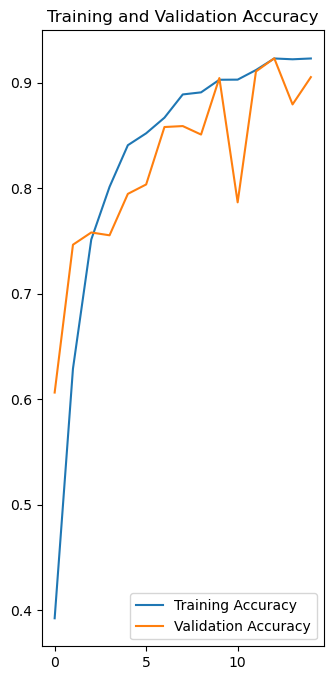

In [55]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(ep), acc, label ="Training Accuracy")
plt.plot(range(ep), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Loss Accuracy')

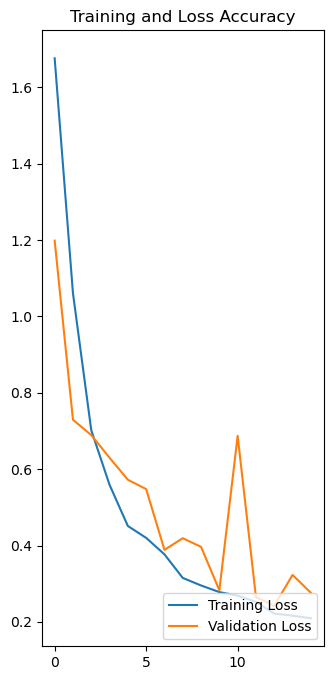

In [56]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(ep), loss, label ="Training Loss")
plt.plot(range(ep), val_loss, label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title("Training and Loss Accuracy")

In [57]:
import numpy as np

First image to predict
First image actual label : Bacterial_spot227
1/1 [==============================] - 1s 931ms/step
Predicted Label : Bacterial_spot227


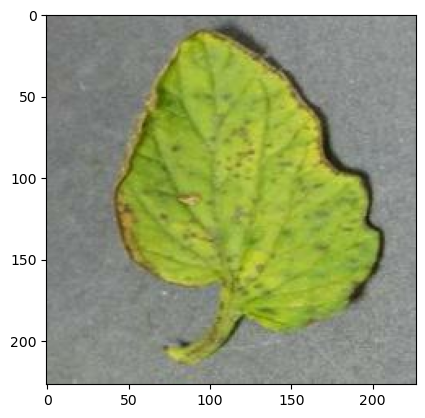

In [58]:
for images_batch , l_b in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = l_b[0]
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label :", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted Label :" ,class_names[np.argmax(batch_prediction[0])]) 

In [86]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

In [72]:
scores = model.evaluate(test_ds)

37/37 [==============================] - 17s 468ms/step - loss: 0.2732 - accuracy: 0.9169


In [73]:
print("Test Loss", scores[0])
print("Test accuracy", scores[1])

Test Loss 0.27317625284194946
Test accuracy 0.916883111000061


In [76]:
test_true_labels = []
predicted_labels = []

In [77]:
for images_batch, true_labels_batch in test_ds:
    batch_predictions = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_predictions, axis=1))
    test_true_labels.extend(true_labels_batch.numpy())

1/1 [==============================] - 1s 512ms/step


In [98]:
report = classification_report(test_true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n",report)

Classification Report:
                                   precision    recall  f1-score   support

               Bacterial_spot227       0.96      0.96      0.96       155
                 Early_blight227       0.84      0.88      0.86        85
                  Late_blight227       0.91      0.93      0.92       166
                    Leaf_Mold227       0.94      0.88      0.91        82
           Septoria_leaf_spot227       0.89      0.87      0.88       138
                  Target_Spot227       0.91      0.84      0.87       123
Tomato_Yellow_Leaf_Curl_Virus227       0.97      0.98      0.98       114
          Tomato_mosaic_virus227       0.92      0.92      0.92        25
      Two-spotted_spider_mite227       0.94      0.89      0.91       144
                      healthy227       0.88      1.00      0.94       123

                        accuracy                           0.92      1155
                       macro avg       0.92      0.91      0.91      1155
            

In [90]:
confusion = confusion_matrix(test_true_labels, predicted_labels)
print("Confusion Matrix:\n", confusion)

Confusion Matrix:
 [[149   3   0   0   0   1   2   0   0   0]
 [  2  75   5   0   3   0   0   0   0   0]
 [  2   7 154   0   2   0   0   0   0   1]
 [  2   1   3  72   4   0   0   0   0   0]
 [  0   3   5   5 120   0   1   1   0   3]
 [  1   0   0   0   4 103   0   0   8   7]
 [  0   0   2   0   0   0 112   0   0   0]
 [  0   0   0   0   2   0   0  23   0   0]
 [  0   0   0   0   0   9   0   1 128   6]
 [  0   0   0   0   0   0   0   0   0 123]]


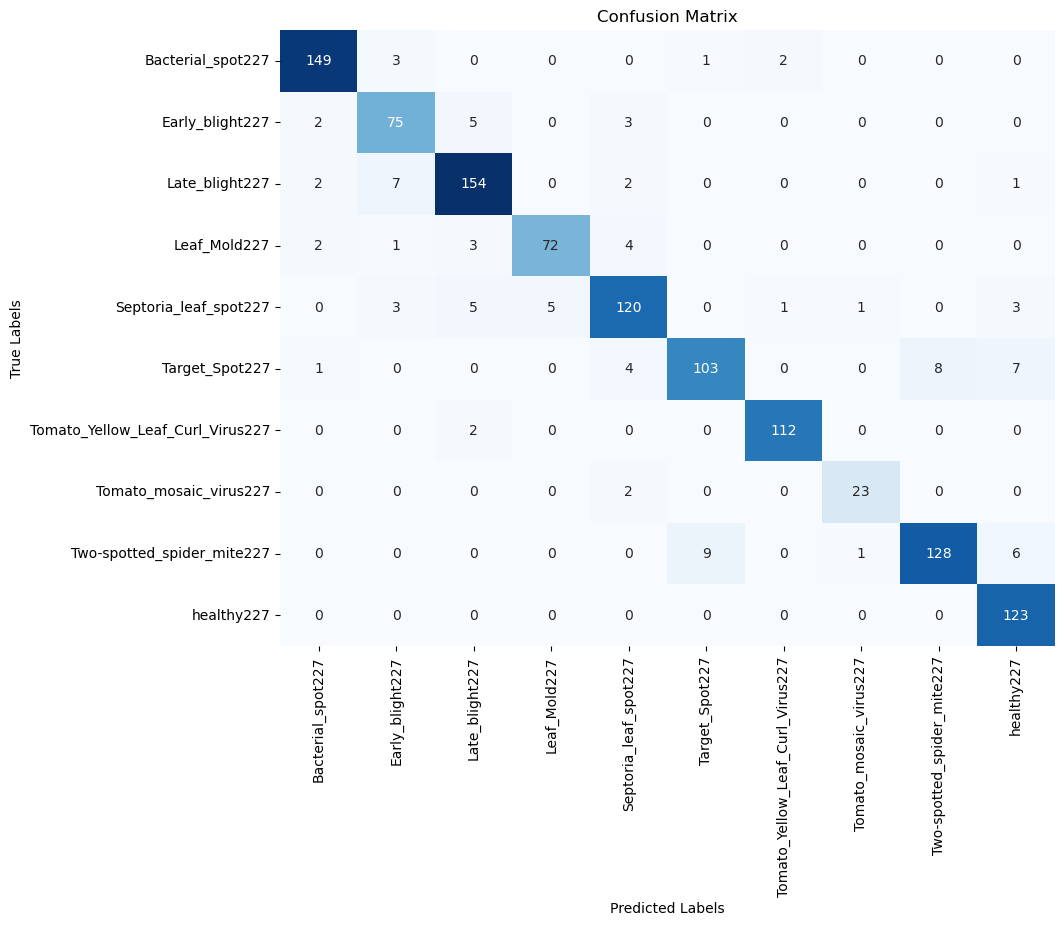

In [93]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [84]:
f1 = f1_score(test_true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.9165215467533686


In [87]:
precision = precision_score(test_true_labels, predicted_labels, average='weighted')
recall = recall_score(test_true_labels, predicted_labels, average='weighted')

In [88]:
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9177637900369343
Recall: 0.9168831168831169
